In [1]:
# Code outline:
# 1. Indoor system - data:
#   a. Read data and parameters
#   b. process data (measurements)
# 2. Outdoor system - data:
#   a. Read data and parameters
#   b. Process data (measurements)
#   c. Build interpolations functions for temperature and light HOBO data
# 3. Offshore system - data:
#   a. Read data and parameters
#   b. Process data (measurements)
#   c. Build interpolations functions for temperature and light IMS data
# 4. Calculate model results for:
#   a. Indoor system
#   b. Outdoor system
#   c. Offshore system
# 5. Calculate errors in the combined df
# df_combined structure:
#System, time, m_exp, m_mod, m_SRE,Nint_exp, Nint_mod, Nint_SRE Next_exp, Next_mod, Next_SRE
# 6... minimize errors?

In [2]:
from __future__ import division
import numpy as np
import scipy as sp
from scipy.integrate import odeint
from scipy import stats
from scipy import interpolate
import math
import matplotlib.pyplot as plt
import pandas as pd # to read excel
print(f"pandas version is {pd.__version__}")
import seaborn as sns
from array import *
import researchpy as rp
import scipy.stats as stats
%matplotlib inline

from myfunctions import *

import datetime

pandas version is 1.0.1


In [3]:
# Functions for optimization (i.e producing random parametric combination)
import SALib
from SALib.sample import saltelli
from SALib.analyze import sobol
from sklearn.linear_model import LinearRegression

In [4]:
# 1. Indoor system
#   a. Read data and parameters from excel file

xl = pd.ExcelFile('../data/Parameters.xlsx')
x2 = pd.ExcelFile('../data/Data.xlsx')

# Import parameters into df1
df1 = xl.parse('Parameters')

# assigmment of parameters to values: 
for key,val in zip(df1.Parameter,df1.Indoor_value):
    exec(key + '=val')
    print(key,val)

# Import indoor data into df2
df2 = x2.parse('Indoor')

df2.head()

umol_to_percent_DW 0.0014
n_days 7.0
Duration 7.0
Nint0 1.85
m0 0.15
Nintcrit 1.0
miu 0.045
Nintmax 5.5
Nintmin 0.48
Ks 14.0
Vmax 225.0
Z 0.178
KI 15.0
K0 1.5
Ka 0.05
Topt 18.0
Tmin 5.0
Tmax 35.0
n 5.0
losses20 0.0016
teta 1.047
Sopt 18.0
Smin 3.0
Smax 45.0
Shigh 30.0
Slow 12.0
KN 1.1
dNextoutdt 0.05
dNextindt 0.0
dmoutdt 0.0


,Sample,Exp,Sleeve,Week,Stage,Timei,Timeh,Time,DW,mmi,...,Weighing,Trimming,Frequency,Amplitude,Duration,Flux,Sporulated,Comment,Day,Comment2
0,0.0,1,0,0.0,i,"2019,3,12,13,0","2019,3,12,13,0","2019,3,12,13,0",0.750,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN
1,0.7,1,0,0.0,f,"2019,3,12,13,0","2019,3,12,13,0","2019,3,19,13,0",0.753,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN
2,1.0,1,1,1.0,i,"2019,3,19,13,0","2019,3,19,13,0","2019,3,19,13,0",0.144,NaN,...,NaN,NaN,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN
3,2.0,1,2,1.0,i,"2019,3,19,13,0","2019,3,19,13,0","2019,3,19,13,0",0.153,NaN,...,NaN,NaN,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN
4,3.0,1,3,1.0,i,"2019,3,19,13,0","2019,3,19,13,0","2019,3,19,13,0",0.159,NaN,...,NaN,NaN,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN


In [5]:
# b. process data (indoor measurements)

    # 1. Convert Time into hours
T = []
for i in df2['Sample'][:]:
    T1 = df2['Timei'][df2['Sample'].values.tolist().index(i)]
    T2 = df2['Time'][df2['Sample'].values.tolist().index(i)]
    T.append(Time_to_Hours(T1,T2))
df2['T'] = T

    # 2. Make a temp DF (df2_temp) by filtering the original df - remove 'wierd' results (i.e sporulation) 

df2_Reduced = df2[(df2.Treatment != 'Acclimation') & (df2.Week <= 3) & (df2.Stage != 'i') & (df2.Sporulated == 'No')]
df2_Reduced

,Sample,Exp,Sleeve,Week,Stage,Timei,Timeh,Time,DW,mmi,...,Trimming,Frequency,Amplitude,Duration,Flux,Sporulated,Comment,Day,Comment2,T
11,1.7,1,1,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.408,4.8,...,0.0,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN,165
12,2.7,1,2,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.426,5.1,...,0.0,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN,165
13,3.7,1,3,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.330,5.3,...,0.0,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN,165
14,4.7,1,4,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.267,5.2,...,0.0,1.0,2000.0,4.0,2000.0,No,NaN,NaN,NaN,165
15,5.7,1,5,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.267,4.8,...,0.0,1.0,2000.0,4.0,2000.0,No,NaN,NaN,NaN,165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,145.7,5,5,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.321,NaN,...,0.0,3.0,500.0,168.0,1500.0,No,NaN,NaN,NaN,501
469,146.7,5,6,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.297,NaN,...,0.0,3.0,500.0,168.0,1500.0,No,NaN,NaN,NaN,501
470,147.7,5,7,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.357,NaN,...,0.0,5.0,200.0,168.0,1000.0,No,NaN,NaN,NaN,501
471,148.7,5,8,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.336,NaN,...,0.0,5.0,200.0,168.0,1000.0,No,NaN,NaN,NaN,501


In [6]:
# 4. Calculate model results for:
#   a. Indoor system
    # I. Produce an array ("m/Nint/Next_mod_all") of all model results (hours 1-504) for each treatment

In [7]:
df2_Reduced

,Sample,Exp,Sleeve,Week,Stage,Timei,Timeh,Time,DW,mmi,...,Trimming,Frequency,Amplitude,Duration,Flux,Sporulated,Comment,Day,Comment2,T
11,1.7,1,1,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.408,4.8,...,0.0,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN,165
12,2.7,1,2,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.426,5.1,...,0.0,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN,165
13,3.7,1,3,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.330,5.3,...,0.0,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN,165
14,4.7,1,4,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.267,5.2,...,0.0,1.0,2000.0,4.0,2000.0,No,NaN,NaN,NaN,165
15,5.7,1,5,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.267,4.8,...,0.0,1.0,2000.0,4.0,2000.0,No,NaN,NaN,NaN,165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,145.7,5,5,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.321,NaN,...,0.0,3.0,500.0,168.0,1500.0,No,NaN,NaN,NaN,501
469,146.7,5,6,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.297,NaN,...,0.0,3.0,500.0,168.0,1500.0,No,NaN,NaN,NaN,501
470,147.7,5,7,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.357,NaN,...,0.0,5.0,200.0,168.0,1000.0,No,NaN,NaN,NaN,501
471,148.7,5,8,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.336,NaN,...,0.0,5.0,200.0,168.0,1000.0,No,NaN,NaN,NaN,501


In [8]:
# optimized parameters: bounds

problem = {
    'num_vars': 4,
    'names': ['µmax', 'Nintcrit','λ20','dNextoutdt'],
    'bounds': [[0.025, 0.05],
               [1, 3],
               [0.001,0.005],
               [0.001,0.2]]
}
print(problem)

{'num_vars': 4, 'names': ['µmax', 'Nintcrit', 'λ20', 'dNextoutdt'], 'bounds': [[0.025, 0.05], [1, 3], [0.001, 0.005], [0.001, 0.2]]}


In [9]:
# number of examined values per parameter - 10
param_values = saltelli.sample(problem, 200)
print(param_values.shape)

(2000, 4)


In [10]:
# model simulations with different parameteric combinations


Y1 = np.zeros([param_values.shape[0]])
Y2 = np.zeros([param_values.shape[0]])

evaluate_model1 = []
evaluate_model2 = []

Temp = 22
S = 39 # fix salinity function and S=40

Treatments = ['1000/1/168','500/2/168','500/3/168','2000/1/168','200/5/168']

r = 0
    
for p, X in enumerate(param_values):
    #miu = X[0]
    #Nintcrit = X[1]
    #KI = X[2]
    #K0 = X[3]
    #Ka = X[4]
    #lossess20 = X[5]
    #dNextoutdt = X[6]
    
    
    miu = X[0]
    Nintcrit = X[1]
    #Ks = X[2]
    #Vmax = X[3]
    #KI = X[4]
    #K0 = X[5]
    #Ka = X[6]
    #n = X[7]
    #Tmax = X[8]
    #Topt = X[9]
    #Tmin = X[10]
    lossess20 = X[2]
    #Sopt = X[12]
    #Smax = X[13]
    #Smin = X[14]
    #teta = X[15]
    dNextoutdt = X[3]
    
    
    #Total_biomass = []
    #Total_N = []
    #NSEA, NEXT, NINT, M, Total_N, T = [],[],[],[],[],[]
    #NSEA_F = []

    TModAll = [] # Each sub-array has the time steps of a specific treatment (periods)
    mExpAllTimes,NintExpAllTimes,NextExpAllTimes = [],[],[]
    mModAll,NintModAll,NextModAll = [],[],[]


    for i in Treatments:
        #print('\nTreatment: ' + str(i))
        df2Temp = df2_Reduced[(df2_Reduced.Treatment == i)]
        mTemp = df2Temp[(np.isnan(df2Temp.DW) != True)]['DW']
        mTimeTemp = df2Temp[(np.isnan(df2Temp.DW) != True)]['T']
        NintTemp = df2Temp[(np.isnan(df2Temp.N) != True)]['N']
        NintTimeTemp = df2Temp[(np.isnan(df2Temp.N) != True)]['T']
        NextTemp = df2Temp[(np.isnan(df2Temp.NH4) != True)]['NH4']
        NextTimeTemp = df2Temp[(np.isnan(df2Temp.NH4) != True)]['T']
        mTemp = df2Temp[(~np.isnan(df2Temp.DW))]['DW']
        mTimeTemp = df2Temp[(~np.isnan(df2Temp.DW))]['T']
        NintTemp = df2Temp[(~np.isnan(df2Temp.N))]['N']
        NintTimeTemp = df2Temp[(~np.isnan(df2Temp.N))]['T']
        NextTemp = df2Temp[(~np.isnan(df2Temp.NH4))]['NH4']
        NextTimeTemp = df2Temp[(~np.isnan(df2Temp.NH4))]['T']
        #print('Number of samples:\nm: ' + str(len(mTimeTemp)) + ' Nint: ' + str(len(NintTimeTemp)) + ' Next: ' + str(len(NextTimeTemp)))

        Tr = []
        Tr = i.split('/')
        Tr = [float(i) for i in Tr]
        Amplitude = Tr[0]
        Period = float(7/Tr[1]) # Period is in hours
        #print(Period)
        Duration = Tr[2]/24

        NEXT, NINT, M, TT = [],[],[],[]

        n_days = Duration*3
        count_periods = 0

        # hour = 0 is 1pm
        # in the indoor settings we have to solve for shorter periods, 
        # at the beginning of the Treatment we reset Nint, Next, m
        # at the beginning of each Period we set Next to the last Amplitude, 
        # m0 to the end of previous solution of ode()
        # 

        # Let's prepare the IO(t) function that will be supplied to odeint 
        # instead of a scalar. 

        all_treatment_hours = np.arange(0,n_days*24,dtype=np.int)

        # 8pm on the first day is zero crossing of this one 8pm - 10m = 7 hours
        offtimes = all_treatment_hours[np.mod(all_treatment_hours - 7,24) == 0]
        offtimes = np.r_[offtimes,all_treatment_hours[-1]+1] # last hour would be whatever

        # 6am on the next day is zero crossing of this one, 6am - 8pm is 10 hours
        ontimes = all_treatment_hours[np.mod(all_treatment_hours - 7 + 10,24) == 0]
        # and the iniital hour as we always start at 1pm, during ontime
        ontimes = np.r_[np.int(0),ontimes]

        # prepare the duty cycle
        I0set = np.zeros_like(all_treatment_hours)
        for s,e in zip(ontimes,offtimes):
            I0set[s:e] = 80

        # if you want to replace it by a "constant" I0 then replace the lines above with
        # the following line and then it will also give you a constant solution you had before

        # I0set = np.ones_like(all_treatment_hours)*80


        I0 = interpolate.interp1d(all_treatment_hours, I0set, bounds_error=False, fill_value="extrapolate")

        for hour in np.arange(0,n_days*24,round(Period*24,0)):
            #print(hour)
            if hour == 0:
                #print('Starting point')
                Nint_0 = Nint0
                m_0 = m0
                Next_0 = Amplitude

            if hour > 0 and np.mod(hour,round(Period*24,0)) == 0:
                count_periods = count_periods + 1

                if count_periods == Tr[1]:
                    #print('Duration')
                    # reset everything, except Nint
                    Nint_0 = NINT[-1][-1]
                    Next_0 = Amplitude
                    m_0 = m0
                    count_periods = 0
                else:
                    # period passed, not Duration
                    # add amplitude, keep going 
                    #print('Period')
                    Next_0 = NEXT[-1][-1] + Amplitude
                    Nint_0 = NINT[-1][-1]
                    m_0 = M[-1][-1]


            # Here we want to send odeint the times of the light sub-period or 
            # darkness sub-period

            x0 = [Next_0,Nint_0,m_0]
            # t = np.linspace(hour,hour+Period*24) # every time we solve ODE for 24 hours * Period
            t = np.arange(hour, hour+Period*24) # can also ask for report on round hours

            x = odeint(controlled_N_new,x0,t,args=(Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,S,Z,KI,K0,Ka,
                                                   Topt,Tmin,Tmax,losses20,teta,Sopt,Smin,Smax,n,umol_to_percent_DW,Temp,I0),printmessg=0,hmax=.1)

            NEXT.append(x[: , 0])
            NINT.append(x[: , 1])
            M.append(x[: , 2])
            TT.append(t)

            t_model = np.hstack(TT)
            Next_model = np.hstack(NEXT)
            Nint_model = np.hstack(NINT)
            m_model = np.hstack(M)

        TModAll.append(TT)
        mExpAllTimes.append(mTimeTemp)
        NintExpAllTimes.append(NintTimeTemp)
        NextExpAllTimes.append(NextTimeTemp)

        mModAll.append(m_model)
        NintModAll.append(Nint_model)
        NextModAll.append(Next_model)
        
    # Adjusts measurment time to model durations - so that maximum biomass measurements are compared to maximum biomass
    # predictions and not to the initial stocking density (m0)

    TModTemp = []
    TModAllOrg = []
    mModReducedAll, NintModReducedAll, NextModReducedAll = [],[],[]
    for j in range(len(TModAll)): # loops over 5 treatments
        #print(j)
        for k in range(len(TModAll[j])): # Loops over periods in each treatment
            Ttemp = TModAll[j][k]
            for l in Ttemp: #The model ends at 504 hours, but some measurement reach also 50 hours. This sets a 504 hour limit
                if l > 504:
                    l = 504
                TModTemp.append(l)
        TModAllOrg.append(TModTemp)
        TModTemp = []

    for j in range(len(TModAll)):
        gm = interpolate.interp1d(TModAllOrg[j], mModAll[j],kind = 'linear')
        mModReduced = []
        for k in mExpAllTimes[j]:
            #print(mExpAllTimes[i])
            if k >= 168 and k < 180:
                k = 167.9
            elif k >= 336 and k < 345:
                k = 335.9
            elif k > 504:
                k = 504
            #print(j)
            mModReduced.append(gm(k-1))

        mModReducedAll.append(mModReduced)
        gNint = interpolate.interp1d(TModAllOrg[j], NintModAll[j],kind = 'linear')
        NintModReduced = []
        for k in NintExpAllTimes[j]:
            if k >= 168 and k < 180:
                k = 167.9
            if k >= 336 and k < 345:
                k = 335.9
            if k > 504:
                k = 504
            NintModReduced.append(gNint(k-1))
        NintModReducedAll.append(NintModReduced)
        gNext = interpolate.interp1d(TModAllOrg[j], NextModAll[j],kind = 'linear')    
        NextModReduced = []
        for k in NextExpAllTimes[j]:
            if k >= 168 and k < 180:
                k = 167.9
            if k >= 336 and k < 345:
                k = 335.9
            if k > 504:
                k = 504
            NextModReduced.append(gNext(k-1))
        NextModReducedAll.append(NextModReduced)

    
    # calculate errors
    mSRE_All,NintSRE_All,NextSRE_All = [],[],[]
    for j in range(len(Treatments)):
        mSRE,NintSRE,NextSRE = [],[],[]
        RMSREmAll,RMSRENintAll = [],[]
        
        df2m = df2_Reduced[(np.isnan(df2_Reduced.DW) != True)&(df2_Reduced.Treatment == Treatments[j])]
        #print('Treatment: ' + str(Treatments[j]) + '\n\nm\n')
        #print('Number of samples: ' + str(len(df2m.Sample)) + '\n')
        l = 0
        for k in df2m.Sample:
            mexp = df2m.DW
            #print(j)
            #print(len(mModReducedAll))
            mmod = mModReducedAll[j]
            mSRE.append(((mexp.iloc[l]-mmod[l])/mmod[l])**2)
            #print('Sample #' + str(math.floor(float(k))))
            #print('Measured biomass: ' + str(round(mexp.iloc[l],3)))
            #print('Modeled biomass: ' + str(round(float(mmod[l]),3)) + '\n')
            l = l + 1
        RMSREm = round((np.mean(mSRE))**0.5,3)
        mSRE_All.append(mSRE)
        #print('The RMSRE of m in treamtment ' + str(Treatments[j]) + ' is: ' + str(RMSREm) + '\n')


        df2Nint = df2_Reduced[(np.isnan(df2_Reduced.N) != True)][(df2_Reduced.Treatment == Treatments[j])]
        #print('\nNint\n')
        #print('Number of samples: ' + str(len(df2Nint.Sample)) + '\n')
        l = 0
        for k in df2Nint.Sample:
            Nintexp = df2Nint.N
            Nintmod = NintModReducedAll[j]
            NintSRE.append(((Nintexp.iloc[l]-Nintmod[l])/Nintmod[l])**2)
            #print('Sample #' + str(math.floor(float(k))))
            #print('Measured Nint: ' + str(round(float(Nintexp.iloc[l]),3)))     
            #print('Modeled Nint: ' + str(round(float(Nintmod[l]),3)) + '\n')        
            l = l + 1
        RMSRENint = round((np.mean(NintSRE))**0.5,3)
        NintSRE_All.append(NintSRE)
        #print('\nThe RMSRE of Nint in treamtment ' + str(Treatments[j]) + ' is: ' + str(RMSRENint) + '\n')

        df2Next = df2_Reduced[(np.isnan(df2_Reduced.NH4) != True)][(df2_Reduced.Treatment == Treatments[j])]
        #print('\nNext\n')
        #print('Number of samples: ' + str(len(df2Next.Sample)) + '\n')
        l = 0
        for k in df2Next.Sample:
            Nextexp = df2Next.NH4
            if Nextexp.iloc[l] < 0:
                Nextexp.iloc[l] = 0
            Nextmod = NextModReducedAll[j]
            NextSRE.append(((Nextexp.iloc[l]-Nextmod[l])/Nextmod[l])**2)
            #print('Sample #' + str(math.floor(float(k))))
            #print('Measured Next: ' + str(round(float(Nextexp.iloc[l]),3)))     
            #print('Modeled Next: ' + str(round(float(Nextmod[l]),3)) + '\n')        
            l = l + 1
        RMSRENext = round((np.mean(NextSRE))**0.5,3)
        NextSRE_All.append(NextSRE)
        #print('\nThe RMSRE of Next in treamtment ' + str(Treatments[j]) + ' is: ' + str(RMSRENext) + '\n')
    #print('End of treatment ' + str(Treatments[j]) + '\n')
    

    mSRE_AllTemp = []
    for i in range(len(mSRE_All)):
        for j in range(len(mSRE_All[i])):
            mSRE_AllTemp.append(mSRE_All[i][j])
    RMSREm = round((np.mean(mSRE_AllTemp))**0.5,3)

    NintSRE_AllTemp = []
    for i in range(len(NintSRE_All)):
        for j in range(len(NintSRE_All[i])):
            NintSRE_AllTemp.append(NintSRE_All[i][j])
    RMSRENint = round((np.mean(NintSRE_AllTemp))**0.5,3)
    
    evaluate_model1.append(RMSREm)
    evaluate_model2.append(RMSRENint)
    #evaluate_model3.append(RMSRENext)

    Y1[p] = round(evaluate_model1[-1],3)
    Y2[p] = round(evaluate_model2[-1],3)
    print(r)
    r = r+1

C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:257: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:273: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\meiro\Anaconda3new\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999


In [11]:
min(Y1),min(Y2)

(0.276, 0.249)

In [12]:
print(min(Y1))
print(np.mean(Y1))
print(np.std(Y1))
print(np.median(Y1))
print(max(Y1))

0.276
0.32130349999999996
0.039017334452138064
0.312
0.409


In [13]:
Si1 = sobol.analyze(problem, Y1,print_to_console=True)

Parameter S1 S1_conf ST ST_conf
µmax 1.069948 0.169999 1.067204 0.132133
Nintcrit -0.000048 0.000085 0.000003 0.000005
λ20 0.000000 0.000000 0.000000 0.000000
dNextoutdt -0.000048 0.000085 0.000003 0.000005

Parameter_1 Parameter_2 S2 S2_conf
µmax Nintcrit -0.005266 0.206614
µmax λ20 -0.005848 0.206433
µmax dNextoutdt -0.005266 0.206614
Nintcrit λ20 -0.000094 0.000302
Nintcrit dNextoutdt -0.000094 0.000302
λ20 dNextoutdt 0.000000 0.000000


In [14]:
print(min(Y2))
print(np.mean(Y2))
print(np.std(Y2))
print(np.median(Y2))
print(max(Y2))

0.249
0.556918
0.2591342128627557
0.483
1.389


In [15]:
Si2 = sobol.analyze(problem, Y2,print_to_console=True)

Parameter S1 S1_conf ST ST_conf
µmax 0.380650 0.146675 0.594272 0.141183
Nintcrit 0.000054 0.000154 0.000001 0.000001
λ20 0.000000 0.000000 0.000000 0.000000
dNextoutdt 0.509365 0.135514 0.634931 0.144293

Parameter_1 Parameter_2 S2 S2_conf
µmax Nintcrit 0.055439 0.189589
µmax λ20 0.055296 0.189520
µmax dNextoutdt 0.143678 0.248382
Nintcrit λ20 -0.000046 0.000155
Nintcrit dNextoutdt -0.000040 0.000203
λ20 dNextoutdt 0.000000 0.000000


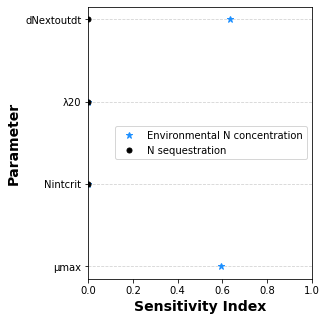

In [16]:
fig,ST2 = plt.subplots(1,1,sharex=True,figsize=(4,5))
#ST2.plot(Si3['ST'],problem['names'],'s',markersize=5,color='dimgray')
ST2.plot(Si2['ST'],problem['names'],'*',markersize=7,color='dodgerblue')
ST2.plot(Si1['ST'],problem['names'],'.',markersize=10,color='black')


ST2.set_xlabel('Sensitivity Index',fontsize=14, weight="bold")
ST2.set_ylabel('Parameter',fontsize=14, weight="bold")
ST2.set_xlim([0, 1])
ST2.set_axisbelow(True)
ST2.yaxis.grid(color='lightgray', linestyle='dashed')
ST2.legend(['Environmental N concentration','N sequestration','Biomass production'])


name = 'fig3.png' 
fig.savefig(fname=name, dpi=600)

In [17]:
a = param_values.T

a

array([[3.04931641e-02, 3.20068359e-02, 3.04931641e-02, ...,
        4.97680664e-02, 4.97680664e-02, 4.97680664e-02],
       [1.19335938e+00, 1.19335938e+00, 2.81445312e+00, ...,
        2.32128906e+00, 2.32128906e+00, 2.32128906e+00],
       [3.07421875e-03, 3.07421875e-03, 3.07421875e-03, ...,
        1.46289062e-03, 4.95117188e-03, 4.95117188e-03],
       [1.35674805e-01, 1.35674805e-01, 1.35674805e-01, ...,
        6.73657227e-02, 1.14200684e-01, 6.73657227e-02]])

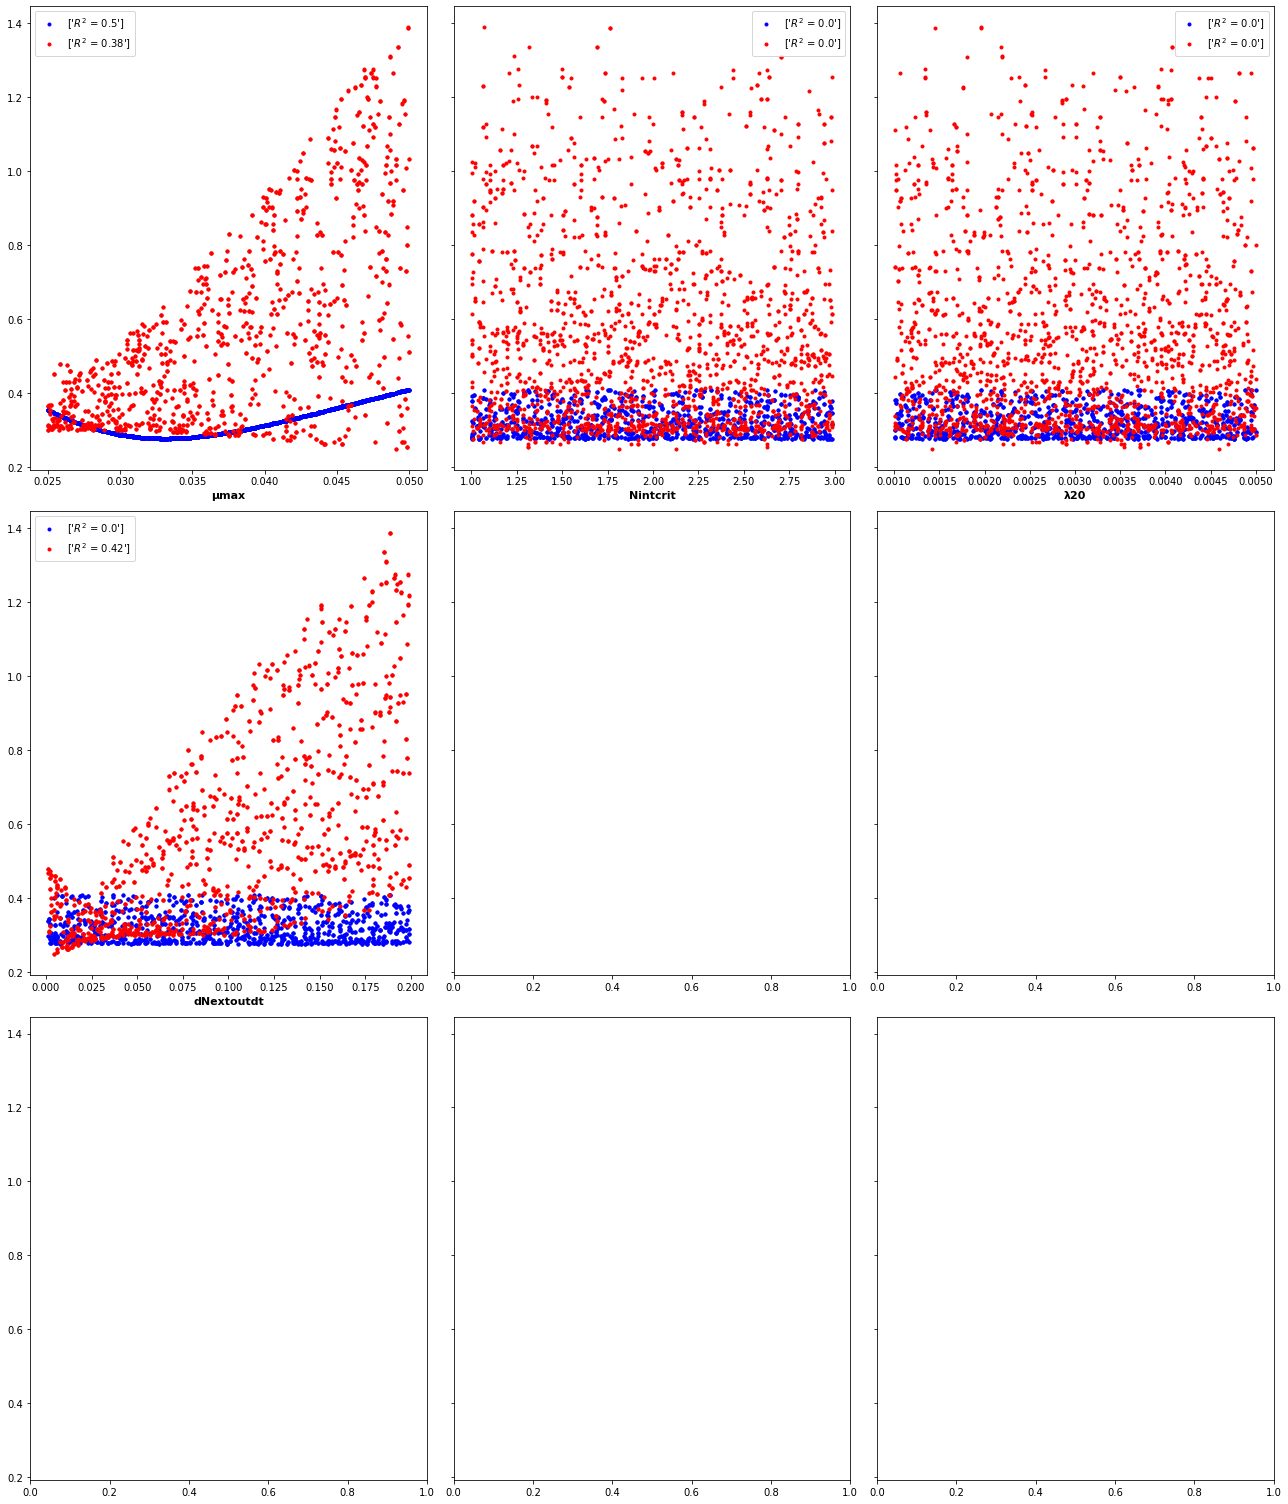

In [18]:
Best_index = []
for i in range(len(Y1)):
    if (Y1[i] < 5) & (Y2[i] < 5):
        #print("parameters of index " + str(i) + " give error " + str(Y[i]) + "\n")
        Best_index.append(i)
        
b = param_values[Best_index].T

#print(b)
fig,ax0 = plt.subplots(3,3,figsize=(18,21),sharey=True)#,sharex=True)

for j in range(len(b)):
    ax0.flat[j].plot(b[j],Y1[Best_index],'.',markersize=6,color = 'blue')
    ax0.flat[j].plot(b[j],Y2[Best_index],'.',markersize=6,color = 'red')
    ax0.flat[j].set_xlabel(str(problem['names'][j]),fontsize=11, weight="bold")
    #ax0.flat[j].set_ylabel('RMSRE',fontsize=12, weight="bold")
    #ax0.flat[j].set_xlim(problem['bounds'][0])
    
    # regression line and coefficient for m:
    mm, bb = np.polyfit(b[j], Y1[Best_index], 1)
    #ax0.flat[j].plot(b[j], mm*b[j] + bb,'.',color = 'darkblue',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    model = LinearRegression()
    model.fit(x, Y1[Best_index])
    model = LinearRegression().fit(x, Y1[Best_index])
    r_sq = model.score(x, Y1[Best_index])
    #print('KI coefficient of determination:', r_sq)
    #ax0.flat[j].legend(['$R^{2}$ = ' + str(round(r_sq,2))])

    # regression line and coefficient for Nint:
    NN, cc = np.polyfit(b[j], Y2[Best_index], 1)
    #ax0.flat[j].plot(b[j], mm*b[j] + bb,'.',color = 'darkblue',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    modelN = LinearRegression()
    modelN.fit(x, Y2[Best_index])
    modelN = LinearRegression().fit(x, Y2[Best_index])
    r_sqN = modelN.score(x, Y2[Best_index])
    #print('KI coefficient of determination:', r_sq)
    ax0.flat[j].legend([['$R^{2}$ = ' + str(round(r_sq,2))],['$R^{2}$ = ' + str(round(r_sqN,2))]])


plt.tight_layout()
plt.show()

name = 'Indoor Error plots.png' 
    
fig.savefig(fname=name, dpi=600)

In [19]:
dfP = pd.DataFrame(param_values[0:-1])
dfY1 = pd.DataFrame(Y1[0:-1])
dfY2 = pd.DataFrame(Y2[0:-1])
dfP.to_csv('Indoor_param_values.csv',index=False)
dfY1.to_csv('Indoor_Y1.csv',index=False)
dfY2.to_csv('Indoor_Y2.csv',index=False)

In [20]:
Y3 = pd.read_csv (r'C:\Users\meiro\Desktop\GitHub\notebooks\Indoor_Y1.csv')
Y4 = pd.read_csv (r'C:\Users\meiro\Desktop\GitHub\notebooks\Indoor_Y2.csv')
P = pd.read_csv (r'C:\Users\meiro\Desktop\GitHub\notebooks\Indoor_param_values.csv')

In [21]:
Y3 = Y3.iloc[:,:].values
Y4 = Y4.iloc[:,:].values
P = P.iloc[:,:].values

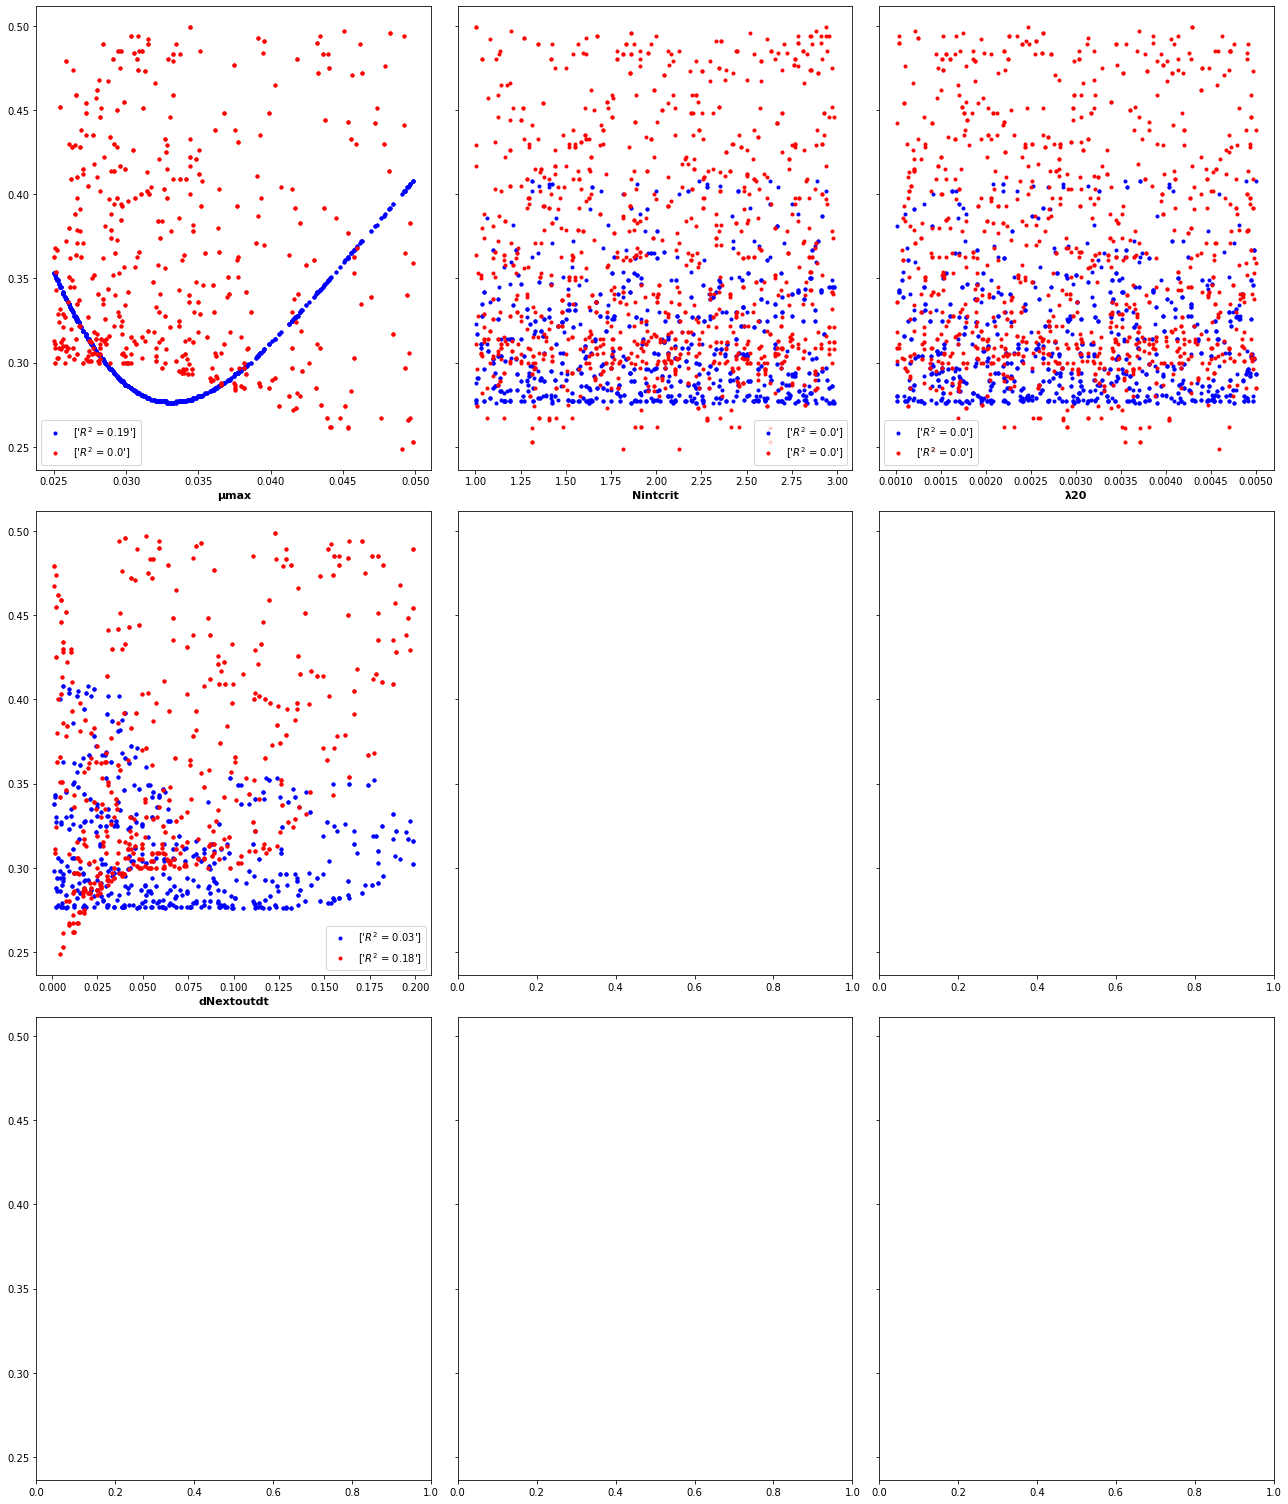

In [22]:
Best_index = []
for i in range(len(Y1)):
    if (Y1[i] < 0.5) & (Y2[i] < 0.5):
        #print("parameters of index " + str(i) + " give error " + str(Y[i]) + "\n")
        Best_index.append(i)
        
b = param_values[Best_index].T

#print(b)
fig,ax0 = plt.subplots(3,3,figsize=(18,21),sharey=True)#,sharex=True)

for j in range(len(b)):
    ax0.flat[j].plot(b[j],Y1[Best_index],'.',markersize=6,color = 'blue')
    ax0.flat[j].plot(b[j],Y2[Best_index],'.',markersize=6,color = 'red')
    ax0.flat[j].set_xlabel(str(problem['names'][j]),fontsize=11, weight="bold")
    #ax0.flat[j].set_ylabel('RMSRE',fontsize=12, weight="bold")
    #ax0.flat[j].set_xlim(problem['bounds'][0])
    
    # regression line and coefficient for m:
    mm, bb = np.polyfit(b[j], Y1[Best_index], 1)
    #ax0.flat[j].plot(b[j], mm*b[j] + bb,'.',color = 'darkblue',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    model = LinearRegression()
    model.fit(x, Y1[Best_index])
    model = LinearRegression().fit(x, Y1[Best_index])
    r_sq = model.score(x, Y1[Best_index])
    #print('KI coefficient of determination:', r_sq)
    #ax0.flat[j].legend(['$R^{2}$ = ' + str(round(r_sq,2))])

    # regression line and coefficient for Nint:
    NN, cc = np.polyfit(b[j], Y2[Best_index], 1)
    #ax0.flat[j].plot(b[j], mm*b[j] + bb,'.',color = 'darkblue',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    modelN = LinearRegression()
    modelN.fit(x, Y2[Best_index])
    modelN = LinearRegression().fit(x, Y2[Best_index])
    r_sqN = modelN.score(x, Y2[Best_index])
    #print('KI coefficient of determination:', r_sq)
    ax0.flat[j].legend([['$R^{2}$ = ' + str(round(r_sq,2))],['$R^{2}$ = ' + str(round(r_sqN,2))]])


plt.tight_layout()
plt.show()

In [23]:
# II. Make a filtered array including only times of empiric measurement (remove from array results from times in which data was not measured)
# III. Add relevant columns from df2_temp and the model results to a new df_combined